In [7]:
from typing import TypedDict, Optional, Dict,Annotated ,List
from langgraph.graph import StateGraph ,START,END
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langgraph.graph.message import  add_messages
from pydantic import  BaseModel,Field

In [8]:
API_KEY="LNDn2rbGUIGZznn1NXT7U4VcADf-d"
ENDPOINT="https://cloud.olakrutrim.com/v1"
MODEL_NAME="Llama-3.3-70B-Instruct"

llm = ChatOpenAI(api_key=API_KEY, base_url=ENDPOINT, model=MODEL_NAME)


Buisness need 
Gather and Analyze business requirments 
Deffine scope and Granularity 
Identify Fact Tables and Their Measures 
Define Dimensions and Conformed Dimensions
Design the Star Schema Structure
Optimize for Performance and Scalability
Validate, Test, and Document

In [56]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langchain_core.messages import HumanMessage,SystemMessage 

In [ ]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [49]:
print(MessagesState)

<class 'langgraph.graph.message.MessagesState'>


In [51]:
def call_model(state: MessagesState):
    
    def pretty_print(messages):
        print("===Pritning state , hold tight=======") 
        print(state)
        print("===The loop isn't looping please wait===") 
        for msg in messages:
            print("=======")
            print(msg)
            print("=======")
    
    pretty_print(state["messages"])
    response = llm.invoke(state["messages"])
    return {"messages": response}

In [52]:
workflow = StateGraph(state_schema=MessagesState)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

In [57]:
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [54]:
config = {"configurable": {"thread_id": "abc123"}}

In [75]:
from Prompts import  Prompts
print(type(Prompts.gen_analysis_business_need()))

<class 'langchain_core.prompts.chat.ChatPromptTemplate'>


In [74]:

query = "Hi! I'm Bob."
print(Prompts.gen_analysis_business_need())
input_messages = [SystemMessage(Prompts.gen_analysis_business_need().tamplate),HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()  

input_variables=[] input_types={} partial_variables={} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='\n                    You are Codd, a knowledgeable and playful chatbot specialized in Database Administration and Data Modeling. Your mission is to help users refine their business needs for designing an OLAP data store by engaging in a friendly, clear, and jargon-free conversation. Your responses should feel warm and human, not robotic. Follow these guidelines:\n\n                    1. **Listen Carefully:** When a business need is provided, read it thoroughly.\n                    2. **Analyze & Inquire:** Break down the business need into its key components and ask simple, thoughtful questions to gather more details. For example:\n                    - "Could you explain what you mean by \'sales trends\'? Are you looking for daily, weekly, or monthly patterns?"\n                    - "Which product cat

AttributeError: 'ChatPromptTemplate' object has no attribute 'tamplate'

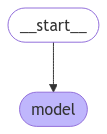

In [59]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [45]:
query = "What's my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

content="Hi! I'm Bob." additional_kwargs={} response_metadata={} id='93a8fdf7-2cdf-4773-afcc-1d16f23731e9'
content="Hello Bob! It's nice to meet you. Is there something I can help you with or would you like to chat?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 41, 'total_tokens': 67, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Llama-3.3-70B-Instruct', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-698baf98-8a56-41b1-b448-61ddb1a8c414-0' usage_metadata={'input_tokens': 41, 'output_tokens': 26, 'total_tokens': 67, 'input_token_details': {}, 'output_token_details': {}}
content="What's my name?" additional_kwargs={} response_metadata={} id='ede12a17-b844-4a61-9c3f-3783aeeb9217'
================================== Ai Message ==================================

Your name is Bob. You told me that when we started talking.


In [46]:

config = {"configurable": {"thread_id": "abc234"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()


content="What's my name?" additional_kwargs={} response_metadata={} id='d115655e-b9f1-4181-b835-03e0290aacd6'
================================== Ai Message ==================================

I don't know your name. I'm a large language model, I don't have the ability to access personal information about you, and we haven't interacted before, so I don't have any context about your identity. If you'd like to share your name with me, I'd be happy to chat with you!


In [47]:
config = {"configurable": {"thread_id": "abc123"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

content="Hi! I'm Bob." additional_kwargs={} response_metadata={} id='93a8fdf7-2cdf-4773-afcc-1d16f23731e9'
content="Hello Bob! It's nice to meet you. Is there something I can help you with or would you like to chat?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 41, 'total_tokens': 67, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Llama-3.3-70B-Instruct', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-698baf98-8a56-41b1-b448-61ddb1a8c414-0' usage_metadata={'input_tokens': 41, 'output_tokens': 26, 'total_tokens': 67, 'input_token_details': {}, 'output_token_details': {}}
content="What's my name?" additional_kwargs={} response_metadata={} id='ede12a17-b844-4a61-9c3f-3783aeeb9217'
content='Your name is Bob. You told me that when we started talking.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_toke

In [29]:
class BuisnessNeedPreProcessed(BaseModel):
    conversions:Annotated[List[str], Field(description="Conversations as stored")]
    processed_technical_conversions:Annotated[List[str],Field(description="")]
    

In [ ]:
def create_conversation_chain_with_memory(buisness_need:str):
    memory= ConversationSummaryBufferMemory()
    pass


In [12]:
class GranularityScope(BaseModel):
    conversions:Annotated[str, Field(description="Conversations as stored")]
    

In [13]:
class SchemaDesign(BaseModel):
        conversions:Annotated[str, Field(description="Conversations as stored")]

In [14]:
class PerformanceOptimization(BaseModel):
    pass

In [15]:
class ErDiagram(BaseModel):
    pass

In [16]:
class CoddState(BaseModel):
    business_need: Annotated[str, Field(description="Original raw business need text as provided by the client")]
    business_need_pre_processed: Annotated[str, Field(description="The pre-processed version of the business need with key points extracted")]
    granularity_scope: Annotated[str, Field(description="Defined granularity and scope of the business process for the schema")]
    schema_design: Annotated[str, Field(description="The designed star schema including fact and dimension definitions")]
    performance_optimization: Annotated[str, Field(description="Details on indexing, partitioning, and aggregation strategies to optimize performance")]
    er_diagram: Annotated[str, Field(description="Information about the generated ER diagram for the schema")]
    documentation: Annotated[str, Field(description="Documentation summarizing the design, decisions, and maintenance guidelines")]
    current_stage: Annotated[str, Field(description="Current processing stage in the Codd pipeline")]
    error: Annotated[str, Field(description="Defined granularity and scope of the business process for the schema")]


In [17]:
class State(TypedDict):
    messages:Annotated[list,add_messages]


graph_builder= StateGraph(State)

In [ ]:

from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory()
conversation = ConversationChain(llm=llm, memory=memory)

initial_prompt = (
    "We need to build a data warehouse that integrates data from our ERP and CRM systems "
    "to improve reporting and decision-making. Ask me any questions to clarify our requirements. "
    "When you have all the information you need, simply reply with 'STOP'."
)

response = conversation.run(initial_prompt)
print("LLM:", response)

while True:
    # Ask the next question or prompt
    next_output = conversation.run("Next question?")
    print("LLM:", next_output)
    
    # Check if the LLM signals that it is done
    if "STOP" in next_output.upper():
        print("LLM decided to stop asking questions.")
        break

    # (Optional) Simulate user responses here. In a real application, you might capture user input.
    user_input = input("Your answer: ")
    conversation.run(user_input)


/tmp/ipykernel_47889/891791678.py:5: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use :meth:`~RunnableWithMessageHistory: https://python.langchain.com/v0.2/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html` instead.
  conversation = ConversationChain(llm=llm, memory=memory)
/tmp/ipykernel_47889/891791678.py:13: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = conversation.run(initial_prompt)


LLM: To clarify your requirements, can you please tell me what specific data entities from the ERP and CRM systems you would like to integrate into the data warehouse? For example, are you looking to include customer information, sales orders, inventory levels, financial transactions, or something else? Additionally, what is the approximate volume of data we're talking about, and what is the desired frequency of data updates - real-time, daily, weekly, or monthly? 

Also, what type of reporting and decision-making are you trying to support with this data warehouse? Are you looking to create dashboards, generate ad-hoc reports, or perform advanced analytics and data mining? 

Lastly, do you have any existing data warehouse or business intelligence tools that we should consider integrating with, such as Tableau, Power BI, or Oracle OBIEE? Or would you like me to recommend some options?
LLM: It seems like you're ready to provide more information. To further clarify your requirements, can 